In [321]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.special

In [322]:
def gen_gmm(n_g, n_sample, low = 1, high = 10):    
    mu = np.random.uniform(size = n_g, low = low, high = high)
    sigma = np.random.uniform(size = n_g)
    prop = np.random.uniform(size = n_g)
    prop = prop/np.sum(prop)
    sample_from = np.random.choice(n_g, n_sample, p=prop)
    samples = np.zeros_like(sample_from).astype('float32')
    for i in range(n_g):
        n = len(samples[sample_from == i])
        samples[sample_from == i] = np.random.normal(mu[i], sigma[i], n)
        
    return samples

In [323]:
def get_gmm_dist(n_g, n_sample, low = 1, high = 10):
    def gen_gmm_func(n_g, n_sample, low = low, high = high):    
        mu = np.random.uniform(size = n_g, low = low, high = high)
        sigma = np.random.uniform(size = n_g)
        prop = np.random.uniform(size = n_g)
        prop = prop/np.sum(prop)
        sample_from = np.random.choice(n_g, n_sample, p=prop)
        samples = np.zeros_like(sample_from).astype('float32')
        for i in range(n_g):
            n = len(samples[sample_from == i])
            samples[sample_from == i] = np.random.normal(mu[i], sigma[i], n)
    
    return 0

In [324]:
from functools import partial
import numpy as np
import matplotlib.pyplot as plt

class memoize(object):
    """
       Cache the return value of a method
        
       This class is meant to be used as a decorator of methods. The return value
       from a given method invocation will be cached on the instance whose method
       was invoked. All arguments passed to a method decorated with memoize must
       be hashable.
        
       If a memoized method is invoked directly on its class the result will not
       be cached. Instead the method will be invoked like a static method:
       class Obj(object):
           @memoize
           def add_to(self, arg):
               return self + arg
       Obj.add_to(1) # not enough arguments
       Obj.add_to(1, 2) # returns 3, result is not cached
        
       Script borrowed from here:
       MIT Licensed, attributed to Daniel Miller, Wed, 3 Nov 2010
       http://code.activestate.com/recipes/577452-a-memoize-decorator-for-instance-methods/
    """
    def __init__(self, func):
        self.func = func
    def __get__(self, obj, objtype=None):
        if obj is None:
            return self.func
        return partial(self, obj)
    def __call__(self, *args, **kw):
        obj = args[0]
        try:
            cache = obj.__cache
        except AttributeError:
            cache = obj.__cache = {}
        key = (self.func, args[1:], frozenset(kw.items()))
        try:
            res = cache[key]
        except KeyError:
            res = cache[key] = self.func(*args, **kw)
        return res



class Bspline():
    """
       Numpy implementation of Cox - de Boor algorithm in 1D

       inputs:
           knot_vector: Python list or Numpy array containing knot vector 
                        entries
           order: Order of interpolation, e.g. 0 -> piecewise constant between 
                  knots, 1 -> piecewise linear between knots, etc.
       outputs:
           basis object that is callable to evaluate basis functions at given 
           values of knot span
    """
    
    def __init__(self, knot_vector, order):
        """Initialize attributes"""
        self.knot_vector = np.array(knot_vector)
        self.p = order

        #Dummy calls to the functions for memory storage
        self.__call__(0.0)
        self.d(0.0)
        
        
    def __basis0(self, xi):
        """Order zero basis"""
        return np.where(np.all([self.knot_vector[:-1] <=  xi, 
                                xi < self.knot_vector[1:]],axis=0), 1.0, 0.0)
    
    def __basis(self, xi, p, compute_derivatives=False):
        """
           Recursive Cox - de Boor function to compute basis functions and 
           optionally their derivatives
        """
        
        if p == 0:
            return self.__basis0(xi)
        else:
            basis_p_minus_1 = self.__basis(xi, p - 1)
        
        first_term_numerator = xi - self.knot_vector[:-p] 
        first_term_denominator = self.knot_vector[p:] - self.knot_vector[:-p]
        
        second_term_numerator = self.knot_vector[(p + 1):] - xi
        second_term_denominator = (self.knot_vector[(p + 1):] - 
                                   self.knot_vector[1:-p])
                
        
        #Change numerator in last recursion if derivatives are desired
        if compute_derivatives and p == self.p:
            
            first_term_numerator = p
            second_term_numerator = -p
            
        #Disable divide by zero error because we check for it
        with np.errstate(divide='ignore', invalid='ignore'):
            first_term = np.where(first_term_denominator != 0.0, 
                                  (first_term_numerator / 
                                   first_term_denominator), 0.0)
            second_term = np.where(second_term_denominator != 0.0,
                                   (second_term_numerator / 
                                    second_term_denominator), 0.0)
        
        return  (first_term[:-1] * basis_p_minus_1[:-1] + 
                 second_term * basis_p_minus_1[1:])
            
    
    @memoize
    def __call__(self, xi):
        """
           Convenience function to make the object callable.  Also 'memoized'
           for speed.
        """
        return self.__basis(xi, self.p, compute_derivatives=False)
    
    @memoize
    def d(self, xi):
        """
           Convenience function to compute derivate of basis functions.  
           'Memoized' for speed.
        """
        return self.__basis(xi, self.p, compute_derivatives=True)
    
    def plot(self):
        """
           Convenience function to plot basis functions over full 
           range of knots.
        """
        
        x_min = np.min(self.knot_vector)
        x_max = np.max(self.knot_vector)
        
        x = np.linspace(x_min, x_max, num=1000)
        
        N = np.array([self(i) for i in x]).T;
        
        for n in N:
            
            plt.plot(x,n)
            
        return plt.show()
    
    def dplot(self):
        """
           Convenience function to plot derivatives of basis functions over 
           full range of knots.
        """
        
        x_min = np.min(self.knot_vector)
        x_max = np.max(self.knot_vector)
        
        x = np.linspace(x_min, x_max, num=1000)
        
        N = np.array([self.d(i) for i in x]).T;
        
        for n in N:
            
            plt.plot(x,n)
            
        return plt.show()

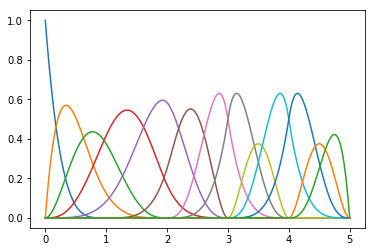

In [325]:
knot_vector = [0,0,0,0,0,1,2,2,3,3,3,4,4,4,5,5,5,5]
basis = Bspline(knot_vector,4)

%matplotlib inline
basis.plot()

In [326]:
x = np.linspace(0,5,num=1000)
bs = np.array([basis(i) for i in x])

In [327]:
pi = np.random.uniform(size = 13)
r = np.random.uniform(size = 13)
s = np.random.uniform(size = 13, high = 5, low = 1)

In [328]:
pi_vec = np.dot(bs, pi)
r_vec = np.dot(bs, r)
s_vec = np.dot(bs, s)

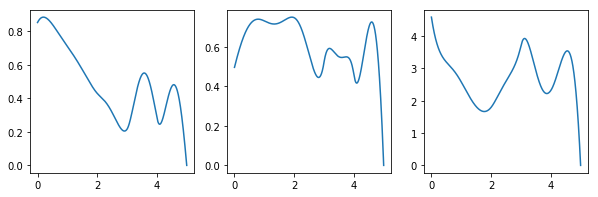

In [329]:
plt.figure(figsize = (10,3))
plt.subplot(1,3,1)
plt.plot(x,pi_vec)
plt.subplot(1,3,2)
plt.plot(x,r_vec)
plt.subplot(1,3,3)
plt.plot(x,s_vec)

In [330]:
x = np.random.uniform(low = 0, high = 5, size = 10000)
bs = np.array([basis(i) for i in x])
pi_values = np.dot(bs, pi)
r_values = np.dot(bs,r)
s_values = np.dot(bs, s)

In [331]:
f1 = np.random.beta(a = r_values, b = s_values)

In [332]:
p = np.zeros_like(x)
h = np.zeros_like(x)
for i,item in enumerate(x):
    rnd = np.random.uniform()
    if rnd < pi_values[i]:
        p[i] = np.random.uniform()
        h[i] = 0
    else:
        p[i] = np.random.beta(a = r_values[i], b = s_values[i])
        h[i] = 1

In [333]:
p[p<1e-40] = 1e-40

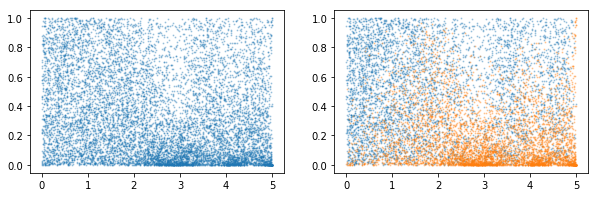

In [334]:
plt.figure(figsize = (10,3))
plt.subplot(1,2,1)
plt.scatter(x, p, 1, alpha = 0.3)
plt.subplot(1,2,2)
plt.scatter(x[h==0], p[h==0], 1, alpha = 0.3)
plt.subplot(1,2,2)
plt.scatter(x[h==1], p[h==1], 1, alpha = 0.3)

In [335]:
with open('data.csv', 'w') as f:
    f.write('x_value, p_value, h\n')
    for i in range(len(x)):
        f.write("{}, {}, {}\n".format(x[i],p[i], h[i]))

In [336]:
bs = np.array([basis(i) for i in x])

In [337]:
pi_esti = np.random.uniform(size = 13)
r_esti = np.random.uniform(size = 13)
s_esti = np.random.uniform(size = 13, high = 5, low = 1)

In [338]:
ll = np.sum(np.log(np.dot(bs, pi_esti) + (1-np.dot(bs, pi_esti)) \
                   * 1/(scipy.special.beta(np.dot(bs, r_esti), np.dot(bs, s_esti))) \
                   * ((p) ** (np.dot(bs, r_esti)-1)) * ((1-p + 1e-10) **  (np.dot(bs, s_esti)- 1))))
print ll

3134.43966515


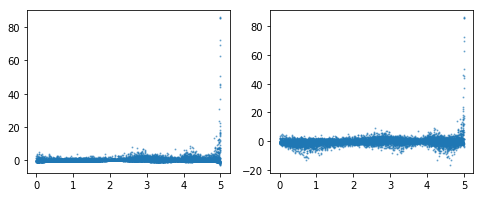

In [339]:
lli = np.log(np.dot(bs, pi_esti) + (1-np.dot(bs, pi_esti)) \
                   * 1/(scipy.special.beta(np.dot(bs, r_esti), np.dot(bs, s_esti))) \
                   * (p ** (np.dot(bs, r_esti)-1)) * ((1-p + 1e-10) **  (np.dot(bs, s_esti)- 1)))

li = np.dot(bs, pi_esti) + (1-np.dot(bs, pi_esti)) \
                   * 1/(scipy.special.beta(np.dot(bs, r_esti), np.dot(bs, s_esti))) \
                   * (p ** (np.dot(bs, r_esti)-1)) * ((1-p + 1e-10) **  (np.dot(bs, s_esti)- 1))

lbi = np.log(1/(scipy.special.beta(np.dot(bs, r_esti), np.dot(bs, s_esti))) \
                   * (p ** (np.dot(bs, r_esti)-1)) * ((1-p + 1e-10) **  (np.dot(bs, s_esti)- 1)))

bi = 1/(scipy.special.beta(np.dot(bs, r_esti), np.dot(bs, s_esti))) \
                   * (p ** (np.dot(bs, r_esti)-1)) * ((1-p + 1e-10) **  (np.dot(bs, s_esti)- 1))


plt.figure(figsize  = (8,3))
plt.subplot(1,2,1)
plt.scatter(x, lli, 1, alpha = 0.5)
plt.subplot(1,2,2)
plt.scatter(x, lbi, 1, alpha = 0.5)

In [340]:
ll_hist = []
for i in range(1000):
    
    lli = np.log(np.dot(bs, pi_esti) + (1-np.dot(bs, pi_esti)) \
                   * 1/(scipy.special.beta(np.dot(bs, r_esti), np.dot(bs, s_esti))) \
                   * (p ** (np.dot(bs, r_esti)-1)) * ((1-p + 1e-10) **  (np.dot(bs, s_esti)- 1)))

    li = np.dot(bs, pi_esti) + (1-np.dot(bs, pi_esti)) \
                       * 1/(scipy.special.beta(np.dot(bs, r_esti), np.dot(bs, s_esti))) \
                       * (p ** (np.dot(bs, r_esti)-1)) * ((1-p + 1e-10) **  (np.dot(bs, s_esti)- 1))

    lbi = np.log(1/(scipy.special.beta(np.dot(bs, r_esti), np.dot(bs, s_esti))) \
                       * (p ** (np.dot(bs, r_esti)-1)) * ((1-p + 1e-10) **  (np.dot(bs, s_esti)- 1)))

    bi = 1/(scipy.special.beta(np.dot(bs, r_esti), np.dot(bs, s_esti))) \
                       * (p ** (np.dot(bs, r_esti)-1)) * ((1-p + 1e-10) **  (np.dot(bs, s_esti)- 1))


    
    pi_grad = np.dot(1/li * (1-bi), bs)
    b_r = np.expand_dims((bi * (np.log(p) - scipy.special.digamma(np.dot(bs, r_esti)) \
           + scipy.special.digamma(np.dot(bs, r_esti) + np.dot(bs, s_esti)))),1) * bs
    b_s = np.expand_dims((bi * (np.log(1-p + 1e-10) - scipy.special.digamma(np.dot(bs, s_esti)) \
           + scipy.special.digamma(np.dot(bs, r_esti) + np.dot(bs, s_esti)))),1) * bs
    r_grad = np.dot((1 - np.dot(bs, pi_esti)) * 1/li, b_r)
    s_grad = np.dot((1 - np.dot(bs, pi_esti)) * 1/li, b_s)
    
    
    s_esti += s_grad * 1e-5
    r_esti += r_grad * 1e-5
    pi_esti += pi_grad * 1e-5
    
    ll = np.sum(np.log(np.dot(bs, pi_esti) + (1-np.dot(bs, pi_esti)) \
                   * 1/(scipy.special.beta(np.dot(bs, r_esti), np.dot(bs, s_esti))) \
                   * (p ** (np.dot(bs, r_esti)-1)) * ((1-p + 1e-10) **  (np.dot(bs, s_esti)- 1))))
    ll_hist.append(ll)
    if i%10 == 0:
        print ll

3151.34966852
3288.87599529
3386.73424683
3459.87617386
3516.484446
3561.49221923
3598.06361303
3628.31986582
3653.73296877
3675.35403464
3693.95235415
3710.10324362
3724.24523448
3736.71828506
3747.78991565
3757.67347021
3766.54112989
3774.53335528
3781.76585094
3788.33477942
3794.32071749
3799.79169463
3804.80555211
3809.41179278
3813.65304447
3817.56622727
3821.18349162
3824.53297741
3827.6394324
3830.52471903
3833.20823224
3835.70724589
3838.03720147
3840.21194996
3842.24395556
3844.14446798
3845.92366897
3847.59079745
3849.15425686
3850.62170763
3852.00014721
3853.29597962
3854.51507603
3855.66282794
3856.74419376
3857.76374002
3858.72567774
3859.63389479
3860.49198467
3861.30327223
3862.07083669
3862.79753235
3863.48600721
3864.13871978
3864.75795428
3865.34583446
3865.9043361
3866.43529841
3866.94043442
3867.4213405
3867.87950502
3868.3163163
3868.7330699
3869.13097537
3869.51116235
3869.8746863
3870.22253367
3870.55562679
3870.87482829
3871.18094523
3871.47473291
3871.7568984
3

KeyboardInterrupt: 

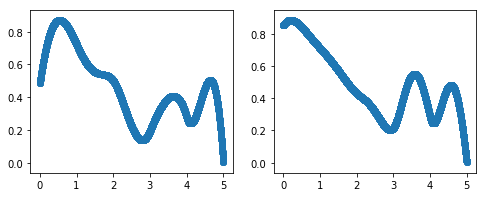

In [341]:
plt.figure(figsize = (8,3))
plt.subplot(1,2,1)
plt.scatter(x, np.dot(bs, pi_esti))
plt.subplot(1,2,2)
plt.scatter(x, np.dot(bs, pi))

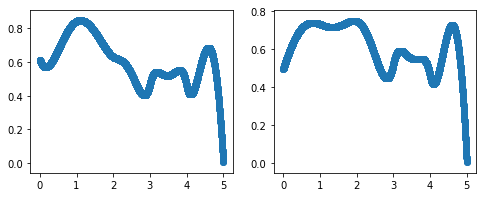

In [342]:
plt.figure(figsize = (8,3))
plt.subplot(1,2,1)
plt.scatter(x, np.dot(bs, r_esti))
plt.subplot(1,2,2)
plt.scatter(x, np.dot(bs, r))

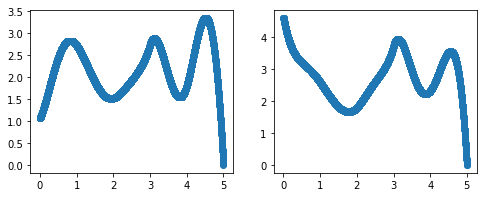

In [343]:
plt.figure(figsize = (8,3))
plt.subplot(1,2,1)
plt.scatter(x, np.dot(bs, s_esti))
plt.subplot(1,2,2)
plt.scatter(x, np.dot(bs, s))

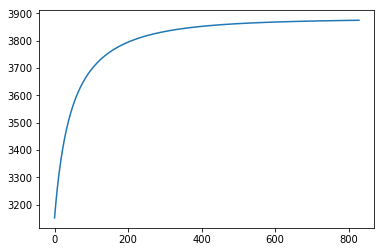

In [344]:
plt.plot(ll_hist)

In [345]:
x2 = np.linspace(0, 5, num=1000)
bs2 = [basis(i) for i in x2]
s_vec = np.dot(bs2, s_esti)
r_vec = np.dot(bs2, r_esti)
pi_vec = np.dot(bs2, pi_esti)

In [346]:
c = 19


In [347]:
po = 1/(r_vec - 1)
threshold = (scipy.special.beta(r_vec, s_vec) * pi_vec * c) ** po
threshold[threshold > 1] = 1


def get_threshold(x):
    bs = basis(x)
    s = np.dot(bs, s_esti)
    r = np.dot(bs, r_esti)
    pi = np.dot(bs, pi_esti)
    po = 1/(r-1)
    threshold = (scipy.special.beta(r, s) * pi * c) ** po
    return threshold


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


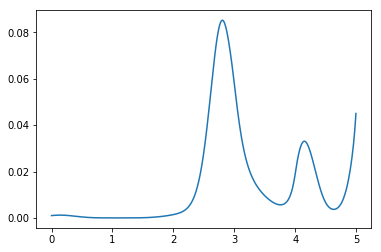

In [348]:
plt.plot(x2, threshold)

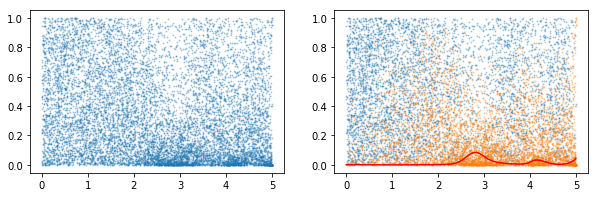

In [349]:
plt.figure(figsize = (10,3))
plt.subplot(1,2,1)
plt.scatter(x, p, 1, alpha = 0.3)
plt.subplot(1,2,2)
plt.scatter(x[h==0], p[h==0], 1, alpha = 0.3)
plt.subplot(1,2,2)
plt.scatter(x[h==1], p[h==1], 1, alpha = 0.3)
plt.plot(x2,threshold, 'r')

In [350]:
rej = np.zeros(len(x))
for i in range(len(x)):
    threshold = get_threshold(x[i])
    if p[i] < threshold:
        rej[i] = 1

In [351]:
np.sum(rej)

1047.0

In [352]:
np.sum(h)

5054.0

In [353]:
np.sum(rej * h) / np.sum(rej)

0.95893027698185296